In [22]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt


finviz_url = 'https://finviz.com/quote.ashx?t='
ticker = 'AFRM'

news_tables = {}

url = finviz_url + ticker

req = Request(url=url, headers={'user-agent': 'my-app'})
response = urlopen(req)

html = BeautifulSoup(response, features='html.parser')
news_table = html.find(id='news-table')

parsed_data = []
soup = news_table
rows = soup.find_all('tr', class_='cursor-pointer has-label')

for row in rows:

    date_data = row.find('td', align='right').get_text(strip=True)
    title = row.find('a', class_='tab-link-news').get_text(strip=True)
    parsed_data.append([date_data, title])
df = pd.DataFrame(parsed_data, columns=['date_data','title'])
    
    


In [23]:
df.to_csv("FinVizAffirm.csv", index=False)

In [ ]:
import pandas as pd
from datetime import datetime

df = pd.read_csv("FinVizAffirm.csv")

today_date = 'Dec-04-23' 
current_date = None
def parse_date_time(row):
    global current_date
    date_part, time_part = row['date_data'].split() if len(row['date_data'].split()) == 2 else (None, row['date_data'])

    if date_part in ['AM', 'PM', None]:
        date_time_str = f"{current_date} {time_part}"
        return datetime.strptime(date_time_str, '%b-%d-%y %I:%M%p')
    else:
        current_date = today_date if 'Today' in date_part else date_part

    return None

df['date_time'] = df.apply(parse_date_time, axis=1)

df = df.dropna(subset=['date_time'])
df.reset_index(drop=True, inplace=True)

print("\nFinal DataFrame:")
print(df)

In [4]:
df = pd.read_csv("Updated_FinVizAffirmDate.csv")

In [5]:
import requests
def get_sentiment(text):
    url = "https://twinword-sentiment-analysis.p.rapidapi.com/analyze/"
    querystring = {"text": text}
    headers = {
		"X-RapidAPI-Key": "",
		"X-RapidAPI-Host": "twinword-sentiment-analysis.p.rapidapi.com"
    }
    
    response = requests.get(url, headers=headers, params=querystring)
    if response.status_code == 200:
        return response.json().get('score', None)
    else:
        return None

df['compound'] = df['title'].apply(get_sentiment)
csv_file_path = 'AffirmSent.csv'
df.to_csv(csv_file_path, index=False)

In [9]:

affirm_stock_data = pd.read_csv("AFRM.csv")
affirm_sentiment_data = pd.read_csv("AffirmSent.csv")
affirm_stock_data['Date'] = pd.to_datetime(affirm_stock_data['Date'])
affirm_sentiment_data['date_time'] = pd.to_datetime(affirm_sentiment_data['date_time'])

affirm_sentiment_data['date'] = affirm_sentiment_data['date_time'].dt.date

average_sentiment_per_day = affirm_sentiment_data.groupby('date')['compound'].mean().reset_index()

average_sentiment_per_day['date'] = pd.to_datetime(average_sentiment_per_day['date'])

merged_data = pd.merge(affirm_stock_data, average_sentiment_per_day, left_on='Date', right_on='date', how='left')

merged_data.drop('date', axis=1, inplace=True)

merged_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,compound
0,2023-08-25,15.090000,18.320000,15.000000,17.790001,17.790001,85735900,0.359347
1,2023-08-28,18.100000,18.129999,17.070000,17.950001,17.950001,29435800,-0.174495
2,2023-08-29,17.950001,19.440001,17.885000,19.150000,19.150000,26439600,NaN
3,2023-08-30,19.049999,20.129999,18.770000,20.030001,20.030001,22398500,NaN
4,2023-08-31,20.110001,21.120001,19.881001,20.809999,20.809999,19815400,-0.126133


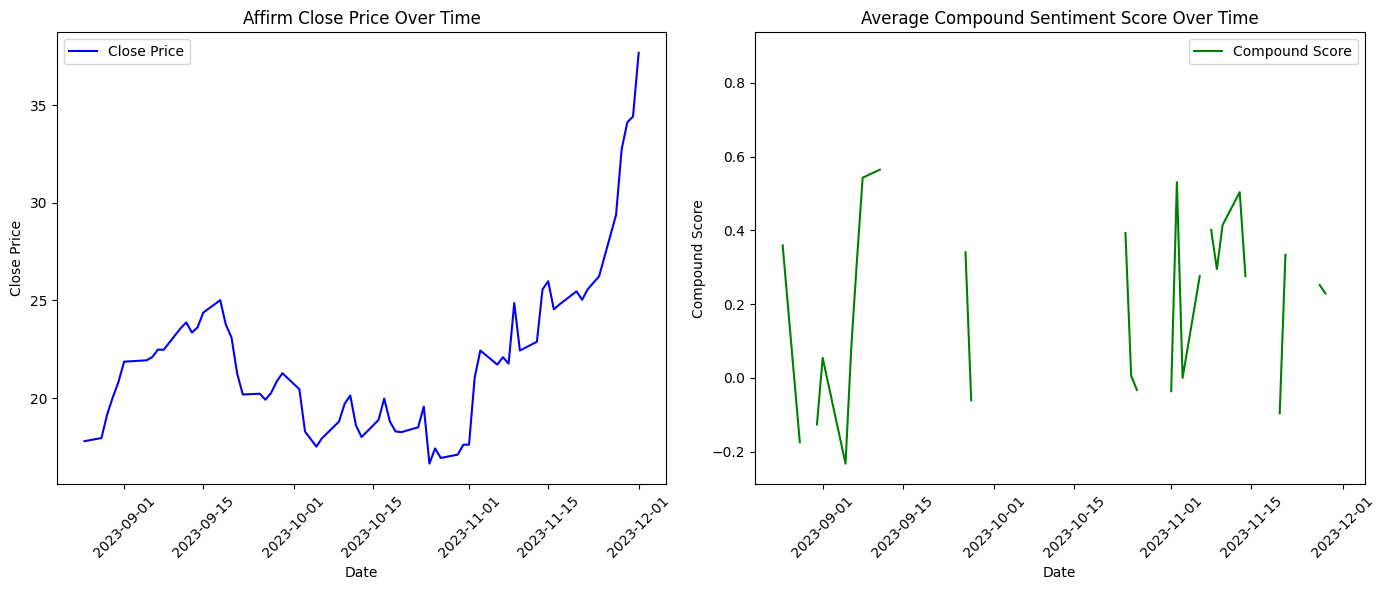

0.23001637257809093

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation = merged_data['Close'].corr(merged_data['compound'])

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(merged_data['Date'], merged_data['Close'], label='Close Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Affirm Close Price Over Time')
plt.xticks(rotation=45)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(merged_data['Date'], merged_data['compound'], label='Compound Score', color='green')
plt.xlabel('Date')
plt.ylabel('Compound Score')
plt.title('Average Compound Sentiment Score Over Time')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

correlation
